In [52]:
import numpy as np
import daft
# import graphviz

import cmdstanpy
import arviz as az

import iqplot
import bebi103

import bokeh.io
bokeh.io.output_notebook()

%config InlineBackend.figure_format='retina'

Loading BokehJS ...

We will consider three generative models described in [this blog post](https://www.inference.vc/causal-inference-2-illustrating-interventions-in-a-toy-example/) by Ferenc Huszár, each of which gives $x, y$. To clarify, consider model zero, in which $x$ and $y$ are drawn from a bivariate Gaussian,

\begin{align}
\begin{pmatrix}
x_i \\
y_i
\end{pmatrix} \sim \text{Norm}\left(
\begin{pmatrix}
\mu_x \\
\mu_y
\end{pmatrix},
\begin{pmatrix}
\sigma_x^2 & \sigma_x\sigma_y\rho\\
\sigma_x\sigma_y\rho & \sigma_y^2
\end{pmatrix}
\right)\;\forall i.
\end{align}

We will specify priors later; for now we will only discuss likelihoods.

We can come up with generative processes, which we will define as models 1, 2, and 3, that result in identically distributed data as would be drawn from model 0.

## Model 1

For model 1, $x$ is drawn out of a Gaussian, and then $y$ is drawn out of a Gaussian based on the values of $x$. Graphically, this is represented as below.

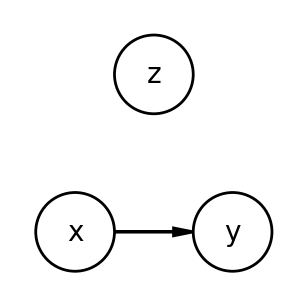

In [2]:
g = daft.PGM()
g.add_node('x', "x", 0, 0)
g.add_node('y', "y", 1, 0)
g.add_node('z', "z", 0.5, 1)
g.add_edge('x', 'y')

g.render();

# Below is how to make it with graphviz
# # We'll use these graph attributes in all graphs
# graph_attrs = dict(    
#     node_attr=dict(style="filled", color="lightgrey", fontname="Helvetica"),
#     edge_attr=dict(arrowsize="0.5"),
#     graph_attr=dict(rankdir='LR', labelloc='t', fontname="Helvetica"),    
# )

# # Build DAG
# g = graphviz.Digraph(**graph_attrs)
# g.graph_attr['label'] = 'Model 1'
# g.node(name="x1", label="x")
# g.node(name="y1", label="y")
# g.node(name="z", label="z")
# g.edge(tail_name="x1", head_name="y1")

# # Display
# g

We can convert the DAG to a statement involving conditional probabilities.

\begin{align}
\pi(x, y) = \pi(y\mid x) \pi(x).
\end{align}

In terms of the parameters specified for model 0, this is

\begin{align}
&z \sim \text{Norm}(\mu_z, \sigma_z),\\[1em]
&x_i \sim \text{Norm}(\mu_x, \sigma_x)\;\forall i,\\[1em]
&y_i \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_x}\,\rho(x_i-\mu_x), \sqrt{1-\rho^2}\,\sigma_y\right)\;\forall i.
\end{align}

## Model 2

For a second model, y is drawn out of a Gaussian and then $y$ is drawn out of a Gaussian based on $x$. Its graphical representation is below.

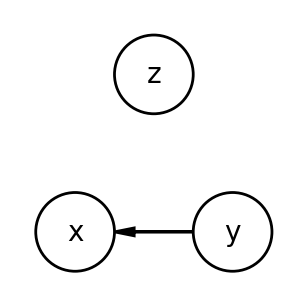

In [3]:
g = daft.PGM()
g.add_node('x', "x", 0, 0)
g.add_node('y', "y", 1, 0)
g.add_node('z', "z", 0.5, 1)
g.add_edge('y', 'x')

g.render();

# Graphviz
# g = graphviz.Digraph(**graph_attrs)
# g.graph_attr['label'] = 'Model 2'
# g.node(name="x1", label="x")
# g.node(name="y1", label="y")
# g.node(name="z", label="z")
# g.edge(tail_name="y1", head_name="x1", ordering='in')

# g

We can convert the DAG to a statement involving conditional probabilities.

\begin{align}
\pi(x, y) = \pi(x\mid y) \pi(y).
\end{align}

The likelihood of the generative model is

\begin{align}
&z \sim \text{Norm}(\mu_z, \sigma_z),\\[1em]
&y_i \sim \text{Norm}(\mu_y, \sigma_y)\;\forall i,\\[1em]
&x_i \sim \text{Norm}\left(\mu_x + \frac{\sigma_x}{\sigma_y}\,\rho(y_i-\mu_y), \sqrt{1-\rho^2}\,\sigma_x\right)\;\forall i.
\end{align}

## Model 3

For model 3, we can have that both x and y are drawn out of a Gaussian based on the value of a third variable $z$. Its graphical representation is below.

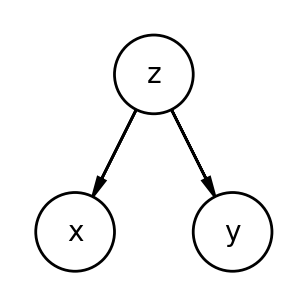

In [4]:
g = daft.PGM()
g.add_node('x', "x", 0, 0)
g.add_node('y', "y", 1, 0)
g.add_node('z', "z", 0.5, 1)
g.add_edge('z', 'x')
g.add_edge('z', 'y')

g.render();

# g = graphviz.Digraph(**graph_attrs)
# g.graph_attr['label'] = 'Model 3'
# g.node(name="z", label="z")
# g.node(name="x", label="x")
# g.node(name="y", label="y")
# g.edge(tail_name="z", head_name="x")
# g.edge(tail_name="z", head_name="y")

# g

We can convert the DAG to a statement involving conditional probabilities.

\begin{align}
\pi(x, y) = \pi(x, y \mid z)\,\pi(z) = \pi(x\mid z)\,\pi(y\mid z)\,\pi(z).
\end{align}

Here, in order to get the target correlation coefficient $\rho$ between $x$ and $y$, we need to define the correlation coefficient between $x$ and $z$ and between $y$ and $z$, such that $\rho_{xz} \rho_{yz} = \rho$. The generative likelihood is thus

\begin{align}
&z \sim \text{Norm}(\mu_z, \sigma_z),\\[1em]
&x_i \sim \text{Norm}\left(\mu_x + \frac{\sigma_x}{\sigma_z}\,\rho_{xz}(z-\mu_z), \sqrt{1-\rho_{xz}^2}\,\sigma_x\right)\;\forall i,\\[1em]
&y_i \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_z}\,\rho_{yz}(z-\mu_z), \sqrt{1-\rho_{yz}^2}\,\sigma_y\right)\;\forall i.
\end{align}

## They all give the same data!

All three models give the same data, which follows from the fact that, given a bivariate Normal distribution,

\begin{align}
\begin{pmatrix}
x \\
y
\end{pmatrix} \sim \text{Norm}\left(
\begin{pmatrix}
\mu_x \\
\mu_y
\end{pmatrix},
\begin{pmatrix}
\sigma_x^2 & \sigma_x\sigma_y\rho\\
\sigma_x\sigma_y\rho & \sigma_y^2
\end{pmatrix}
\right),
\end{align}

the conditional distribution is

\begin{align}
x \mid y = \text{Norm}\left(\mu_x + \frac{\sigma_x}{\sigma_y}\,\rho(y-\mu_y), (1-\rho^2)\sigma_x^2\right).
\end{align}

To demonstrate, let us choose parameter values and draw out of the respective models.

In [3]:
# Instantiate RNG
rng = np.random.default_rng(3252)

# Parameter values
mu_x = 0
mu_y = 1
mu_z = 0
sigma_x = 1
sigma_y = 2
sigma_z = 5
rho = 0.5
rho_zx = 0.8
rho_zy = rho / rho_zx

# How many samples we want to draw
n_samples = 100


# Convenient function to draw out of conditional normal
def cond_norm(cond_samples, mu_1, mu_2, sigma_1, sigma_2, rho):
    return rng.normal(
        mu_2 + sigma_2 / sigma_1 * rho * (cond_samples - mu_1),
        np.sqrt(1 - rho**2) * sigma_2,
    )


# Model 0
x0, y0 = rng.multivariate_normal(
    [mu_x, mu_y],
    [[sigma_x**2, sigma_x * sigma_y * rho], [sigma_x * sigma_y * rho, sigma_y**2]],
    size=n_samples,
).transpose()

# Model 1
x1 = rng.normal(mu_x, sigma_x, size=n_samples)
y1 = cond_norm(x1, mu_x, mu_y, sigma_x, sigma_y, rho)

# Model 2
y2 = rng.normal(mu_y, sigma_y, size=n_samples)
x2 = cond_norm(y2, mu_y, mu_x, sigma_y, sigma_x, rho)

# Model 3
z = rng.normal(mu_z, sigma_z, size=n_samples)
x3 = cond_norm(z, mu_z, mu_x, sigma_z, sigma_x, rho_zx)
y3 = cond_norm(z, mu_z, mu_y, sigma_z, sigma_y, rho_zy)

p = bokeh.plotting.figure(
    frame_width=200, frame_height=200, x_axis_label="x", y_axis_label="y"
)

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]
legend_items = [
    ("Model 0", [p.scatter(x0, y0, alpha=0.3, color=colors[0])]),
    ("Model 1", [p.scatter(x1, y1, alpha=0.3, color=colors[1])]),
    ("Model 2", [p.scatter(x2, y2, alpha=0.3, color=colors[2])]),
    ("Model 3", [p.scatter(x3, y3, alpha=0.3, color=colors[3])]),
]

p.add_layout(bokeh.models.Legend(items=legend_items, click_policy="hide"), "right")

bokeh.io.show(p)

## Conditional distributions

We will now consider how $y$ is conditioned on a specific value of $x$, say $x_0$. Specifically, we seek to compute

\begin{align}
f(y\mid x=x_0) = \frac{f(x=x_0, y)}{f(x=x_0)}.
\end{align}

Let us perform this calculation for each of the models.

### Model 0

For Model 0, we can directly use the above result for the conditional distribution of a bivariate normal to get

\begin{align}
y\mid x=x_0 \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_x}\,\rho(x_0-\mu_x),\sqrt{1-\rho^2}\,\sigma_y\right),
\end{align}

### Model 1

For Model 1, $x$ is independent of $y$, so the marginal pdf of $x$ is

\begin{align}
f(x) = \frac{1}{\sqrt{2\pi\sigma_x^2}}\,\mathrm{e}^{-\frac{(x-\mu_x)^2}{2\sigma_x^2}}.
\end{align}

The joint distribution is

\begin{align}
f(x, y) = \frac{1}{\sqrt{2\pi\sigma_x^2}}\,\exp\left[-\frac{(x-\mu_x)^2}{2\sigma_x^2}\right]\,\frac{1}{\sqrt{2\pi(1-\rho^2)\sigma_y^2}}\,\exp\left[-\frac{\left(y- \mu_y - \frac{\sigma_y}{\sigma_x}\,\rho(x-\mu_x)\right)^2}{2(1-\rho^2)\sigma_y^2}\right].
\end{align}

Therefore,

\begin{align}
f(y\mid x) = \frac{f(x, y)}{f(x)} = \frac{1}{\sqrt{2\pi(1-\rho^2)\sigma_y^2}}\,\exp\left[-\frac{\left(y- \mu_y - \frac{\sigma_y}{\sigma_x}\,\rho(x-\mu_x)\right)^2}{2(1-\rho^2)\sigma_y^2}\right].
\end{align}

Therefore, for Model 1,

\begin{align}
y\mid x=x_0 \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_x}\,\rho(x_0-\mu_x),\sqrt{1-\rho^2}\,\sigma_y\right),
\end{align}

the same as Model 0.

### Model 2

For Model 2, observations of $x$ are dependent on $y$, so we cannot immediately state the marginal distribution $f(x)$. In this case, the joint distribution is

\begin{align}
f(x, y) = \frac{1}{\sqrt{2\pi\sigma_y^2}}\,\exp\left[-\frac{(y-\mu_y)^2}{2\sigma_y^2}\right]\,\frac{1}{\sqrt{2\pi(1-\rho^2)\sigma_x^2}}\,\exp\left[-\frac{\left(x- \mu_x - \frac{\sigma_x}{\sigma_y}\,\rho(y-\mu_y)\right)^2}{2(1-\rho^2)\sigma_x^2}\right].
\end{align}

We can therefore compute the marginal distribution as

\begin{align}
f(x) = \int_{-\infty}^\infty\mathrm{d}y\,f(x, y).
\end{align}

Computing the integral and then computing $f(y\mid x) = f(x, y) / f(x)$ involves plenty of algebraic grunge. The result is, unsurprisingly,

\begin{align}
y\mid x=x_0 \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_x}\,\rho(x_0-\mu_x), \sqrt{1-\rho^2}\,\sigma_y\right),
\end{align}

the same as Models 0 and 1.

### Model 3

Finally, for Model 3, we have the joint

\begin{align}
&f(x, y, z) = \frac{\exp\left[-\frac{1}{2}\left(\left(\frac{z-\mu_z}{\sigma_z}\right)^2 + \left(x-\mu_x-\frac{\sigma_x}{\sigma_z}\,\rho_{xz}(z-\mu_z)\right)^2 + \left(y-\mu_y-\frac{\sigma_y}{\sigma_z}\,\rho_{xz}(z-\mu_z)\right)^2\right)\right]}{\sqrt{(2\pi)^3\sigma_z^2(1-\rho_{xz}^2)(1-\rho_{yz}^2)\sigma_x^2\sigma_y^2}}.
\end{align}

First, we integrate with respect to $z$ to get

\begin{align}
f(x, y) = \int_{-\infty}^\infty\mathrm{d}z\,f(x, y, z) = \frac{\exp\left[ -\frac{1}{2} \left( \frac{(x - \mu_x)^2}{\sigma_x^2} + \frac{(y - \mu_y)^2}{\sigma_y^2} - 2 \frac{\rho}{\sigma_x \sigma_y} (x - \mu_x)(y - \mu_y) \right) \right]}{2 \pi \sigma_x \sigma_y \sqrt{1 - \rho^2}}.
\end{align}

We recognize this result $f(x, y)$ as a bivariate normal, so we can use the result from Model 0 and immediately write, again, that

\begin{align}
y\mid x=x_0 \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_x}\,\rho(x_0-\mu_x), \sqrt{1-\rho^2}\,\sigma_y\right).
\end{align}

Indeed, all three models have the same conditional distribution!

## Interventional distribution

We now consider an *intervention*, in which we *fix* $x$ to have value $x_0$. This intervention means that we fundamentally change the graphs describing the data generation process. Since we are fixing $x$, and input arrow to the $x$ node is deleted.

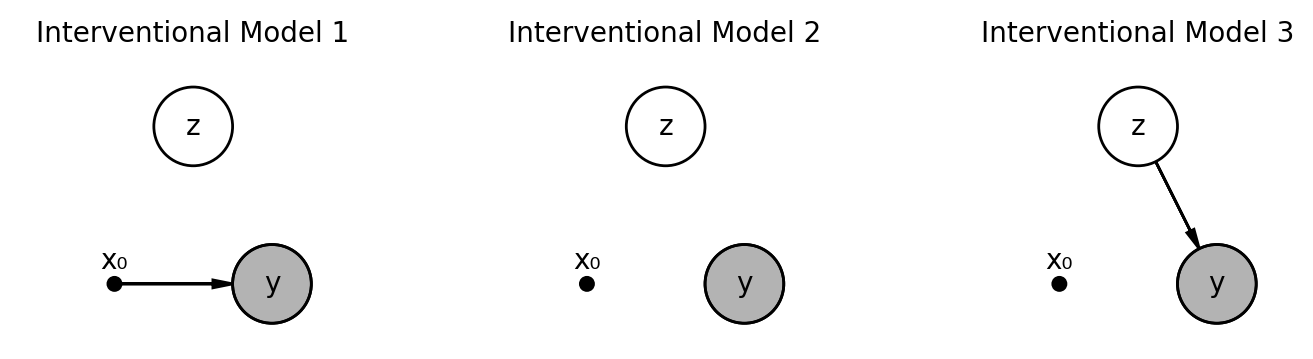

In [13]:
g = daft.PGM()
g.add_text(-0.5, 1.5, 'Interventional Model 1')
g.add_node('x1', "x₀", 0, 0, fixed=True)
g.add_node('y1', "y", 1, 0, observed=True)
g.add_node('z1', "z", 0.5, 1)
g.add_edge('x1', 'y1')

dx = 3
g.add_text(-0.5 + dx, 1.5, 'Interventional Model 2')
g.add_node('x2', "x₀", 0 + dx, 0, fixed=True)
g.add_node('y2', "y", 1 + dx, 0, observed=True)
g.add_node('z2', "z", 0.5 + dx, 1)

dx = 6
g.add_text(-0.5 + dx, 1.5, 'Interventional Model 3')
g.add_node('x3', "x₀", 0 + dx, 0, fixed=True)
g.add_node('y3', "y", 1 + dx, 0, observed=True)
g.add_node('z3', "z", 0.5 + dx, 1)
g.add_edge('z3', 'y3')

g.render();

Interventional Model 1 is identical to Model 1, so

\begin{align}
y\mid do(x=x_0) \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_x}\,\rho(x_0-\mu_x),\sqrt{1-\rho^2}\,\sigma_y\right).
\end{align}

For Interventional Model 2, we have

\begin{align}
y \mid do(x=x_0) \sim \text{Norm}(\mu_y, \sigma_y).
\end{align}

Finally, for Interventional Model 3, we have

\begin{align}
\pi(y, z \mid do(x=x_0)) = \pi(y\mid z)\,\pi(z),
\end{align}

such that

\begin{align}
\pi(y\mid do(x=x_0)) = \int\mathrm{d}z\,\pi(y\mid z)\,\pi(z).
\end{align}

We have

\begin{align}
&z \sim \text{Norm}(\mu_z, \sigma_z),\\[1em]
&y \mid z \sim \text{Norm}\left(\mu_y + \frac{\sigma_y}{\sigma_z}\,\rho_{yz}(z-\mu_z), \sqrt{1-\rho_{yz}^2}\,\sigma_y\right).
\end{align}

Marginalizing over $z$, we have

\begin{align}
y\mid do(x=x_0) \sim \text{Norm}(\mu_y, \sigma_y),
\end{align}

the same as Interventional Model 2.

So, if we look at the interventional distributions, Interventional Model 1 will be different than other other two models, highlighting the causal link between X and Y.

## More complex example

Let us now consider a more complex model, given in Fig. 3.6 of Pearl's *Causality* book.

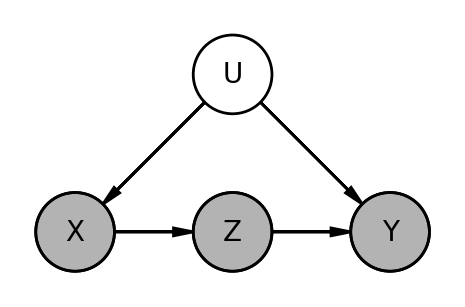

In [12]:
g = daft.PGM()
g.add_node('X', "X", 0, 0, observed=True)
g.add_node('Z', "Z", 1, 0, observed=True)
g.add_node('Y', "Y", 2, 0, observed=True)
g.add_node('U', "U", 1, 1)
g.add_edge('U', 'X')
g.add_edge('U', 'Y')
g.add_edge('X', 'Z')
g.add_edge('Z', 'Y')

g.render();

Here, U is unobserved and X, Y, and Z are observed. The conditioning associated with this DAG is

\begin{align}
\pi(x, y, z, u) = \pi(y \mid u, z)\,\pi(z\mid x)\,\pi(x\mid u)\,\pi(u)
= \pi(y \mid u, z)\,\pi(z\mid x)\,\pi(x\mid u)\,\pi(u)
\end{align}

We are primarily interested in Y and its causal relationship with Z. We therefore wish to compute $\pi(y\mid do(z))$. We will use MCMC to do it.

Let us first write down a full Bayesian model.

\begin{align}
&\mu_u, \mu_x, \mu_z, \mu_y \sim \text{Norm}(0, 10),\\[1em]
&\sigma_u, \sigma_x, \sigma_z, \sigma_y \sim \text{HalfNorm}(1),\\[1em]
&u \sim \text{Norm}(\mu_u, \sigma_u)\\[1em]
&x \sim \text{Norm}(u, \sigma_x)\\[1em]
&z \sim \text{Norm}(x, \sigma_z)\\[1em]
&y \sim \text{Norm}(u + z, \sigma_y).
\end{align}

If we consider an interventional model where we set $z = z_0$, our DAG is as follows.

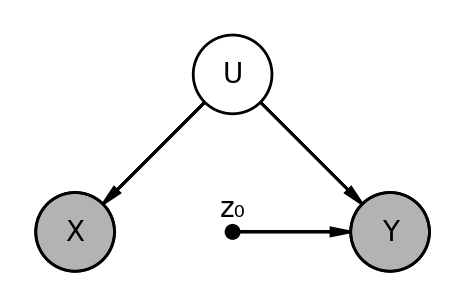

In [17]:
g = daft.PGM()
g.add_node('X', "X", 0, 0, observed=True)
g.add_node('Z', "z₀", 1, 0, fixed=True)
g.add_node('Y', "Y", 2, 0, observed=True)
g.add_node('U', "U", 1, 1)
g.add_edge('U', 'X')
g.add_edge('U', 'Y')
g.add_edge('Z', 'Y')

g.render();

The generative model for this is

\begin{align}
&\mu_u, \mu_z, \mu_y \sim \text{Norm}(0, 10),\\[1em]
&\sigma_u, \sigma_z, \sigma_y \sim \text{HalfNorm}(1),\\[1em]
&u \sim \text{Norm}(\mu_u, \sigma_u)\\[1em]
&x \sim \text{Norm}(u, \sigma_x)\\[1em]
&y \sim \text{Norm}(u + z_0, \sigma_y).
\end{align}

Let's specify some parameters and generate some data.

In [70]:
N = 50
mu_u = 0
sigma_x, sigma_y, sigma_z, sigma_u = 1, 1.5, 0.5, 2

u = rng.normal(mu_u, sigma_u, size=N)
x = rng.normal(u, sigma_x)
z = rng.normal(x, sigma_z)
y = rng.normal(u + z, sigma_y)
z_interventional = 9.0

data = dict(N=N, x=x, y=y, z=z, z_interventional=z_interventional)

Now, we can code up the model and sampling out of the interventional distribution in Stan.

```stan
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
  vector[N] z;
  real z_interventional;
}


parameters {
  real mu_u;
  real<lower=0> sigma_u;
  real<lower=0> sigma_x;
  real<lower=0> sigma_y;
  real<lower=0> sigma_z;

  // Unobserved
  vector[N] u;
}


model {
  mu_u ~ normal(0, 10);
  sigma_u ~ normal(0, 1);
  sigma_x ~ normal(0, 1);
  sigma_y ~ normal(0, 1);
  sigma_z ~ normal(0, 1);

  u ~ normal(mu_u, sigma_u);
  x ~ normal(u, sigma_x);
  z ~ normal(x, sigma_z);
  y ~ normal(u + z, sigma_y);
}


generated quantities {
  array[N] real y_ppc;
  array[N] real y_interventional;

  for (i in 1:N) {
    y_ppc[i] = normal_rng(u[i] + z[i], sigma_y);
    y_interventional[i] = normal_rng(u[i] + z_interventional, sigma_y);
  }
}
```

Let's let 'er rip!

In [79]:
with bebi103.stan.disable_logging():
    sm = cmdstanpy.CmdStanModel(stan_file='pearl_3.6.stan')
    samples = az.from_cmdstanpy(sm.sample(data=data, iter_sampling=8000, thin=8), posterior_predictive=['y_interventional', 'y_ppc'])

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Let's look at the diagnostics to make sure everything went ok.

In [80]:
bebi103.stan.check_all_diagnostics(samples)

Effective sample size looks reasonable for all parameters.

Rhat looks reasonable for all parameters.

0 of 4000 (0.0%) iterations ended with a divergence.

0 of 4000 (0.0%) iterations saturated the maximum tree depth of 10.

E-BFMI indicated no pathological behavior.


0

Looks ok. Now, let's compare the distribution of data from real and interventional data.

In [81]:
p = iqplot.histogram(samples.posterior_predictive['y_interventional'].values.flatten(), density=True, rug=False)
p = iqplot.histogram(samples.posterior_predictive['y_ppc'].values.flatten(), density=True, rug=False, p=p)
p = iqplot.histogram(y, density=True, rug=False, p=p)
bokeh.io.show(p)